# Verification of Elastic wave equation implementation on a staggered grid using the method of manufactured solutions.
This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, TimeAxis
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (201, 201)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

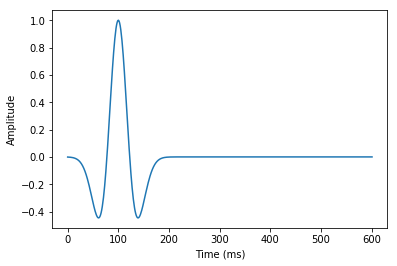

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 600.
dt = (10. / np.sqrt(2.)) / 6.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [1000., 1000.]
src.show()

In [4]:
from examples.seismic import Model
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1*self.spacing[0]

In [5]:
# Now we create the velocity and pressure fields
so = 2 # space order
vx  = TimeFunction(name='vx' , grid=grid, staggered = x,    space_order=so)
vz  = TimeFunction(name='vz' , grid=grid, staggered = z,    space_order=so)
txx = TimeFunction(name='txx', grid=grid, staggered = NODE, space_order=so)
tzz = TimeFunction(name='tzz', grid=grid, staggered = NODE, space_order=so)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so)

In [6]:
# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
V_s = 1.0
density = 3.

# The source injection term
src_xx = src.inject(field=txx.forward, expr=src)
src_zz = src.inject(field=tzz.forward, expr=src)

#c1 = 9.0/8.0;
#c2 = -1.0/24.0;

# Thorbecke's parameter notation
cp2 = V_p*V_p
cs2 = V_s*V_s
ro = 1/density

mu = cs2*ro
l = (cp2*ro - 2*mu)

# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))

u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))

u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)

u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

In [7]:
op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)


In [8]:
# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

op()

Operator `Kernel` run in 0.18 s


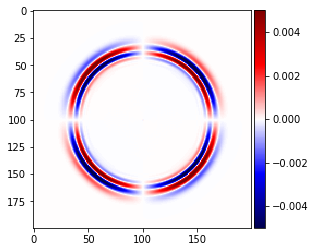

In [9]:
# Let's see what we got....
#plot_image(vx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(vz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(txx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(tzz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")

Operator `Kernel` run in 1.08 s


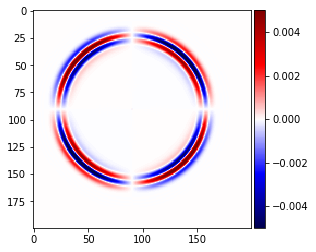

In [10]:
# Now that looks pretty! But let's do it again with a higher space order...
so = 12
vx= TimeFunction(name='vx', grid=grid, staggered=x, space_order=so)
vz = TimeFunction(name='vz', grid=grid, staggered=z, space_order=so)
txx = TimeFunction(name='txx', grid=grid, staggered=NODE, space_order=so)
tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE, space_order=so)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so)

# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))

u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))

u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)

u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

op()

vmin= -.5*1e-2
vmax=  .5*1e-2

#plot_image(vx.data[0] , vmin = vmin, vmax = vmax, cmap="seismic")
#plot_image(vz.data[0] , vmin = vmin, vmax = vmax, cmap="seismic")
#plot_image(txx.data[0], vmin = vmin, vmax = vmax, cmap="seismic")
#plot_image(tzz.data[0], vmin = vmin, vmax = vmax, cmap="seismic")
plot_image(txz.data[0], vmin = vmin, vmax = vmax, cmap="seismic")

In [11]:
#import sympy
#from sympy import cos, sin, exp, pprint, sqrt, sin, sinc
#def mms_sol(model):
#    u, v, w, c = sympy.symbols('u v w c')
#     sol = 1e2*sin(2*np.pi*u) * sin(4*np.pi*v)* sin(6*np.pi*w)
#    sol = (1e4*sin(6*np.pi*w) * exp(-(u - .5)**2/.015 - (v-.5)**2/.015) -
#           1e3*sin(4*np.pi*w) *exp(-(u - .45)**2/.0025 - (v-.65)**2/.0025)-
#           5000*sin(8*np.pi*w) *exp(-(u - .65)**2/.0025 - (v-.45)**2/.0015)+
#           1e4*sin(6*np.pi*w) * exp(-(u - .45)**2/.0015 - (v-.45)**2/.0025)-
#           5*1e3*sin(6*np.pi*w) * exp(-(u - .65)**2/.0027 - (v-.65)**2/.0021))
#    source =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
#    x, z = model.grid.dimensions
#    t = model.grid.time_dim
#    
#    sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
#    source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
#    
#    return sol, source

In [12]:
#import sympy
#from sympy import cos, sin, exp, pprint, sqrt, sin, sinc

#def mms_sol_elastic(model):
#    u, v, w, c = sympy.symbols('u v w c')
#     sol = 1e2*sin(2*np.pi*u) * sin(4*np.pi*v)* sin(6*np.pi*w)
#    sol = (1e4*sin(6*np.pi*w) * exp(-(u - .5)**2/.015 - (v-.5)**2/.015) -
#           1e3*sin(4*np.pi*w) *exp(-(u - .45)**2/.0025 - (v-.65)**2/.0025)-
#           5000*sin(8*np.pi*w) *exp(-(u - .65)**2/.0025 - (v-.45)**2/.0015)+
#           1e4*sin(6*np.pi*w) * exp(-(u - .45)**2/.0015 - (v-.45)**2/.0025)-
#           5*1e3*sin(6*np.pi*w) * exp(-(u - .65)**2/.0027 - (v-.65)**2/.0021))
#    source =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
#    x, z = model.grid.dimensions
#    t = model.grid.time_dim
#    
#    sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
#    source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
#    
#    return sol, source

In [13]:
# def get_solution(size, space_order):
#     clear_cache()
    
    
    
    
    
#     # Model
#     v = 1.5 * np.ones((size, size))
#     v[:, 75:] = 2.5
#     v[:, 125:] = 3.0
    
#     model = ModelBench(vp=v, origin=(0., 0.), spacing=(1., 1.), shape=(size, size),
#                        nbpml=0, space_order=0, dtype=np.float64)
    
#     x, z = model.grid.dimensions
#     t = model.grid.time_dim
#     # Grid
#     h = 1./(size - 1)
#     dt = 1e-7
#     nt = 350
#     # Wave equation
#     u = TimeFunction(name="u", grid=model.grid, space_order=space_order, time_order=2, save=nt)
#     u_true = TimeFunction(name="utrue", grid=model.grid, space_order=space_order, time_order=0, save=nt)
#     src = TimeFunction(name="src", grid=model.grid, space_order=space_order, time_order=0, save=nt)

#     sol, source = mms_sol(model)
    
#     wave_eq = Eq(u.forward, 2 * u - u.backward + t.spacing**2/model.m * (u.laplace + src))
#     true_eqq = Eq(u_true, sol)

#     src_eq = Eq(src, source)
    
#     u_1 = Eq(u.subs(t, 1), sol.subs(t, 1))
#     configuration["log-level"] = "ERROR"
#     op = Operator([u_1, true_eqq, src_eq, wave_eq], subs=({t.spacing: dt, x.spacing:h, z.spacing:h}))
#     op.apply()

#     error = np.linalg.norm(u.data[(nt-3), :, :].reshape(-1) -
#                            u_true.data[(nt-3), :, :].reshape(-1), 2)*h
# #     import matplotlib.pyplot as plt
# #     plt.figure()
# #     plt.subplot(131)
# #     plt.imshow(u.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
# #     plt.subplot(132)
# #     plt.imshow(u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
# #     plt.subplot(133)
# #     plt.imshow(u.data[(nt-3), :, :] - u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
# #     plt.show()
#     print("for h = %f and dt= %2.2e ms error is %2.4e" % (h, dt, error))
#     return error


In [93]:
import sympy
from sympy import cos, sin, exp, pprint, sqrt, sin, sinc

def get_solution_elastic(size, space_order):
    clear_cache()
    
    
    # Grid
    h = 1./(size - 1)
    #dt = 1e-7
    nt = 600
    # Initial grid: 1km x 1km, with spacing 100m
    extent = (2000., 2000.)
    shape = (size, size)
    x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
    z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
    grid = Grid(extent=extent, shape=shape, dimensions=(x, z))
    
    # Model
    # Timestep size from Eq. 7 with V_p=6000. and dx=100
    t0, tn = 0., 600.
    dt = (10. / np.sqrt(2.)) / 6.

    time_range = TimeAxis(start=t0, stop=tn, step=dt)
    src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
    src.coordinates.data[:] = [1000., 1000.]
    
        
    # Now we create the velocity and pressure fields
    so = space_order
    vx  = TimeFunction(name='vx',  grid=grid, staggered=x,      space_order=so, time_order=2)
    vz  = TimeFunction(name='vz',  grid=grid, staggered=z,      space_order=so, time_order=2)
    txx = TimeFunction(name='txx', grid=grid, staggered=NODE,   space_order=so, time_order=2)
    tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE,   space_order=so, time_order=2)
    txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so, time_order=2)
    
    # Wave equation
    vx_true  = TimeFunction(name="vx_true" , grid=grid, staggered=x,      space_order=so, time_order=0)
    vz_true  = TimeFunction(name='vz_true' , grid=grid, staggered=z,      space_order=so, time_order=0)
    txx_true = TimeFunction(name='txx_true', grid=grid, staggered=NODE,   space_order=so, time_order=0)
    tzz_true = TimeFunction(name='tzz_true', grid=grid, staggered=NODE,   space_order=so, time_order=0)
    txz_true = TimeFunction(name='txz_true', grid=grid, staggered=(x, z), space_order=so, time_order=0)
    
    
    vx_src  = TimeFunction(name="vx_src"  , grid=grid, staggered=x,      space_order=so, time_order=0)
    vz_src  = TimeFunction(name='vz_src' , grid=grid, staggered=z,      space_order=so, time_order=0)
    txx_src = TimeFunction(name='txx_src', grid=grid, staggered=NODE,   space_order=so, time_order=0)
    tzz_src = TimeFunction(name='tzz_src', grid=grid, staggered=NODE,   space_order=so, time_order=0)
    txz_src = TimeFunction(name='txz_src', grid=grid, staggered=(x, z), space_order=so, time_order=0)
    
    # Now let's try and create the staggered updates
    t = grid.stepping_dim
    time = grid.time_dim

    # We need some initial conditions
    V_p = 4.0
    V_s = 1.0
    density = 3.

    # The source injection term
    src_xx = src.inject(field=txx.forward, expr=src)
    src_zz = src.inject(field=tzz.forward, expr=src)

    #c1 = 9.0/8.0;
    #c2 = -1.0/24.0;

    # Thorbecke's parameter notation
    cp2 = V_p*V_p
    cs2 = V_s*V_s
    ro = 1/density

    mu = cs2*ro
    l = (cp2*ro - 2*mu)
    

    # fdelmodc reference implementation
    u_vx  = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))
    u_vz  = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))
    u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
    u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)
    u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))
    
    #op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)
    
    vx.data[:] = 0.
    vz.data[:] = 0.
    txx.data[:] = 0.
    tzz.data[:] = 0.
    txz.data[:] = 0.
    
    vx_true.data[:] = 0.
    vz_true.data[:] = 0.
    txx_true.data[:] = 0.
    tzz_true.data[:] = 0.
    txz_true.data[:] = 0.
    
    vx_src.data[:] = 0.
    vz_src.data[:] = 0.
    txx_src.data[:] = 0.
    tzz_src.data[:] = 0.
    txz_src.data[:] = 0.

    #op()
    
    

       

    ##############################################################################
    u, v, w, c = sympy.symbols('u v w c')
    #sol = 1*sin(2*np.pi*u) * sin(4*np.pi*v)* sin(6*np.pi*w)* sin(8*np.pi*u)
    sol = (1e4*sin(6*np.pi*w) * exp(-(u - .5)**2/.015 - (v-.5)**2/.015) +
           1e3*sin(4*np.pi*w) *exp(-(u - .45)**2/.0025 - (v-.65)**2/.0025)-
           5000*sin(8*np.pi*w) *exp(-(u - .65)**2/.0025 - (v-.45)**2/.0015)+
           1e4*sin(6*np.pi*w) * exp(-(u - .45)**2/.0015 - (v-.45)**2/.0025)-
           5*1e3*sin(6*np.pi*w) * exp(-(u - .65)**2/.0027 - (v-.65)**2/.0021))
    
    source =  sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    #x, z = grid.dimensions
    #t = grid.time_dim
    
    sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1)})
    source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1)})
    #################################################################################
    
    
    
    wave_eq = u_txz + source
    true_eqq = Eq(txz_true, sol)
    

    src_eq = Eq(txz_src, source)
    
    u_1 = Eq(u.subs(t, 1), sol.subs(t, 1))
    configuration["log-level"] = "ERROR"
    #h = .00125

    #op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz, subs=({t.spacing: dt, x.spacing:h, z.spacing:h}))
    op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)
    #op = Operator([u_txz] + src_xx + src_zz)
    #op = Operator([u_1, true_eqq, src_eq])
    op.apply()

    error = np.linalg.norm(txz.data[(nt-3), :, :].reshape(-1) -
                           txz_true.data[(nt-3), :, :].reshape(-1), 2)*h
    
       

    print("for h = %f and dt= %2.2e ms error is %2.4e" % (h, dt, error))

    
    
    
#  import matplotlib.pyplot as plt
#     plt.figure()
#     plt.subplot(131)
#     plt.imshow(u.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.subplot(132)
#     plt.imshow(u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.subplot(133)
#     plt.imshow(u.data[(nt-3), :, :] - u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.show()



    return error

# MMS

In [105]:
size = [32, 64, 128, 256, 512]

#t = 2
so = [ 2 , 4, 6, 8, 10]
error = np.zeros((len(size), len(so)))
#hh = [0.04, 0.02, 0.01, 0.005, 0.001]
#hh = [1, .5, .25, .125]
# hh = [4*h for h in hh]
for i, s in enumerate(size):
    for j, sso in enumerate(so):
        error[i, j] = get_solution_elastic(s, sso)

for h = 0.032258 and dt= 1.18e+00 ms error is 9.8010e-03
for h = 0.032258 and dt= 1.18e+00 ms error is 1.0446e-02
for h = 0.032258 and dt= 1.18e+00 ms error is 1.0544e-02
for h = 0.032258 and dt= 1.18e+00 ms error is 1.0560e-02
for h = 0.032258 and dt= 1.18e+00 ms error is 1.0564e-02
for h = 0.015873 and dt= 1.18e+00 ms error is 7.3201e-03
for h = 0.015873 and dt= 1.18e+00 ms error is 6.8918e-03
for h = 0.015873 and dt= 1.18e+00 ms error is 6.7713e-03
for h = 0.015873 and dt= 1.18e+00 ms error is 6.7274e-03
for h = 0.015873 and dt= 1.18e+00 ms error is 6.7081e-03
for h = 0.007874 and dt= 1.18e+00 ms error is 2.3333e-03
for h = 0.007874 and dt= 1.18e+00 ms error is 2.2376e-03
for h = 0.007874 and dt= 1.18e+00 ms error is 2.2283e-03
for h = 0.007874 and dt= 1.18e+00 ms error is 2.2269e-03
for h = 0.007874 and dt= 1.18e+00 ms error is 2.2266e-03
for h = 0.003922 and dt= 1.18e+00 ms error is 6.0398e-04
for h = 0.003922 and dt= 1.18e+00 ms error is 5.9668e-04
for h = 0.003922 and dt= 1.18e+

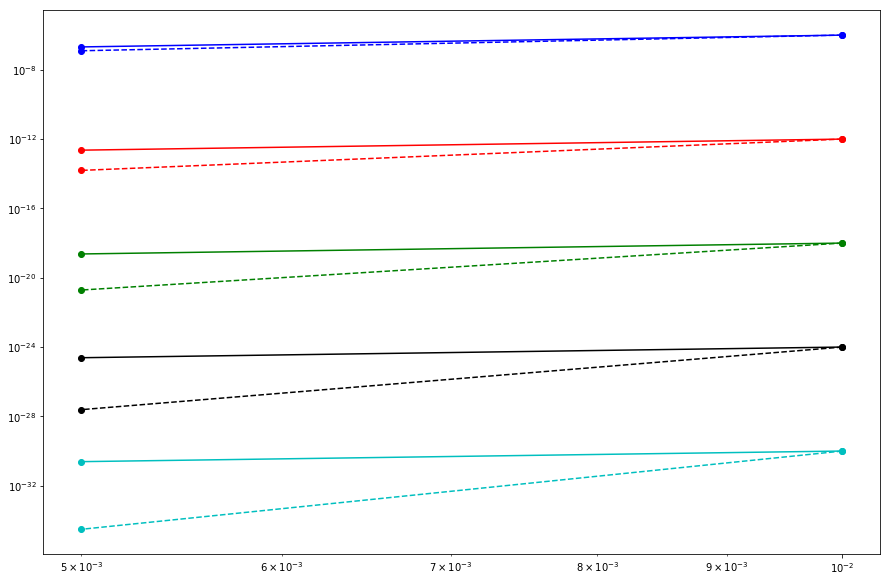

In [104]:
import matplotlib.pyplot as plt
col = ['-ob', '-or', '-og', '-ok', '-oc']
col_2 = ['--ob', '--or', '--og', '--ok', '--oc']
hh = [0.02, 0.01, 0.005, 0.0025]
#hh = [1, .5, .25, .125]
#hh = [4*h for h in hh]
plt.figure(figsize=(15, 10))
for j, sso in enumerate(so):
    plt.loglog(hh[1:3], hh[1]**so[j]*error[1:3, j]/error[1, j], col[j])
    plt.loglog(hh[1:3], [h**so[j] for h in hh][1:3], col_2[j])

# plt.loglog(hh, error[:, 3])
# plt.loglog(hh, [h**so[3] for h in hh])

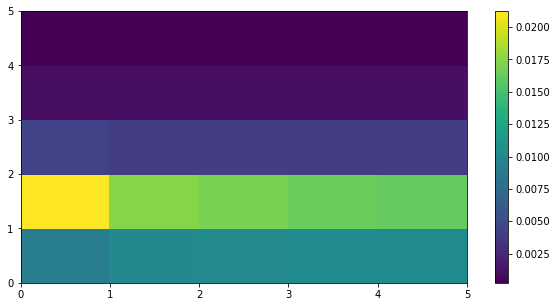

In [99]:
fig = plt.figure(figsize=(10, 5))
im = plt.pcolormesh(error)
fig.colorbar(im)